In [11]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.SeqIO import parse
from scipy.spatial.distance import pdist, squareform, euclidean

from utils import (
    prepare_exp_aa_subst, collect_possible_changes, 
    cdn_spectrum_to_matrix, possible_codons, amino_acid_codes,
    get_equilibrium_freqs, get_equilibrium_probabilities
)

In [2]:
# Assuming you have:
# transition_matrix - 64x64 numpy array
# initial_vector - 1x64 numpy array (or 64x1, will need to transpose if needed)

def simulate_markov(transition_matrix, initial_vector, num_iterations):
    current_state = initial_vector
    data = [current_state]
    for _ in range(num_iterations):
        current_state = np.dot(current_state, transition_matrix)
        data.append(current_state)
        # print(f"Current state after iteration: {current_state[:5]}")
    return data


def simulate_markov_power(transition_matrix, initial_vector, num_iterations):
    powered_matrix = np.linalg.matrix_power(transition_matrix, num_iterations)
    return np.dot(initial_vector, powered_matrix)

## Load aa content

### Load codon counts from refseq

In [3]:
data_cdn_counts = dict()

for rec in parse('./data/refseq_data/cds.fna', 'fasta'):
    if ' ORF1ab polyprotein ' in rec.description or ' ORF1a polyprotein ' in rec.description:
        print(' pass', rec.description)
    else:
        # print(rec.description, len(rec), len(rec) % 3)
        seq = str(rec.seq)
        codons = [seq[i:i+3] for i in range(0, len(rec), 3)]
        assert seq == ''.join(codons)
        gene = ' '.join(rec.description.split()[1:]).split(' [organism=')[0]

        print(gene, codons[-1], len(codons))

        data_cdn_counts[gene] = dict(Counter(codons))

3C-like proteinase [polyprotein=ORF1ab polyprotein] CAA 306
nsp6 [polyprotein=ORF1ab polyprotein] CAG 290
nsp7 [polyprotein=ORF1ab polyprotein] CAA 83
nsp8 [polyprotein=ORF1ab polyprotein] CAG 198
nsp9 [polyprotein=ORF1ab polyprotein] CAA 113
nsp10 [polyprotein=ORF1ab polyprotein] CAG 139
RNA-dependent RNA polymerase [polyprotein=ORF1ab polyprotein] CAG 932
nsp11 [polyprotein=ORF1a polyprotein] GTG 13
helicase [polyprotein=ORF1ab polyprotein] CAA 601
3'-to-5' exonuclease [polyprotein=ORF1ab polyprotein] CAG 527
endoRNAse [polyprotein=ORF1ab polyprotein] CAA 346
2'-O-ribose methyltransferase [polyprotein=ORF1ab polyprotein] AAC 298
surface glycoprotein TAA 1274
ORF3a protein TAA 276
envelope protein TAA 76
membrane glycoprotein TAA 223
 pass NC_045512.2:266-13468,13468-21555 ORF1ab polyprotein [organism=Severe acute respiratory syndrome coronavirus 2] [isolate=Wuhan-Hu-1]
 pass NC_045512.2:266-13483 ORF1a polyprotein [organism=Severe acute respiratory syndrome coronavirus 2] [isolate=Wu

In [4]:
cdn_counts_df = pd.DataFrame(data_cdn_counts).T.fillna(0).astype(int)
cdn_counts_df.to_csv('./data/refseq_data/codon_counts.csv')
cdn_counts_df.head()

,AGT,GGT,TTT,AGA,AAA,ATG,GCA,TTC,CCA,TCT,...,TCC,AGC,GCG,GGG,CCG,TCG,CGG,TAA,TGA,TAG
3C-like proteinase [polyprotein=ORF1ab polyprotein],3,17,12,3,3,10,3,5,5,7,...,0,0,0,0,0,0,0,0,0,0
nsp6 [polyprotein=ORF1ab polyprotein],4,11,17,6,8,17,5,5,1,7,...,1,1,0,0,0,0,0,0,0,0
nsp7 [polyprotein=ORF1ab polyprotein],0,1,1,1,4,4,1,0,0,3,...,1,0,0,0,0,0,0,0,0,0
nsp8 [polyprotein=ORF1ab polyprotein],5,3,4,3,8,9,10,1,2,5,...,1,0,0,0,0,0,0,0,0,0
nsp9 [polyprotein=ORF1ab polyprotein],3,6,3,2,4,2,2,1,1,1,...,1,0,1,0,0,0,0,0,0,0


In [5]:
cdn_counts_dct = cdn_counts_df.sum(0).to_dict()

In [6]:
cdn_counts_df.sum(axis=1).sort_values(ascending=False)

nsp3 [polyprotein=ORF1ab polyprotein]                             1945
surface glycoprotein                                              1274
RNA-dependent RNA polymerase [polyprotein=ORF1ab polyprotein]      932
nsp2 [polyprotein=ORF1ab polyprotein]                              638
helicase [polyprotein=ORF1ab polyprotein]                          601
3'-to-5' exonuclease [polyprotein=ORF1ab polyprotein]              527
nsp4 [polyprotein=ORF1ab polyprotein]                              500
nucleocapsid phosphoprotein                                        420
endoRNAse [polyprotein=ORF1ab polyprotein]                         346
3C-like proteinase [polyprotein=ORF1ab polyprotein]                306
2'-O-ribose methyltransferase [polyprotein=ORF1ab polyprotein]     298
nsp6 [polyprotein=ORF1ab polyprotein]                              290
ORF3a protein                                                      276
membrane glycoprotein                                              223
nsp8 [

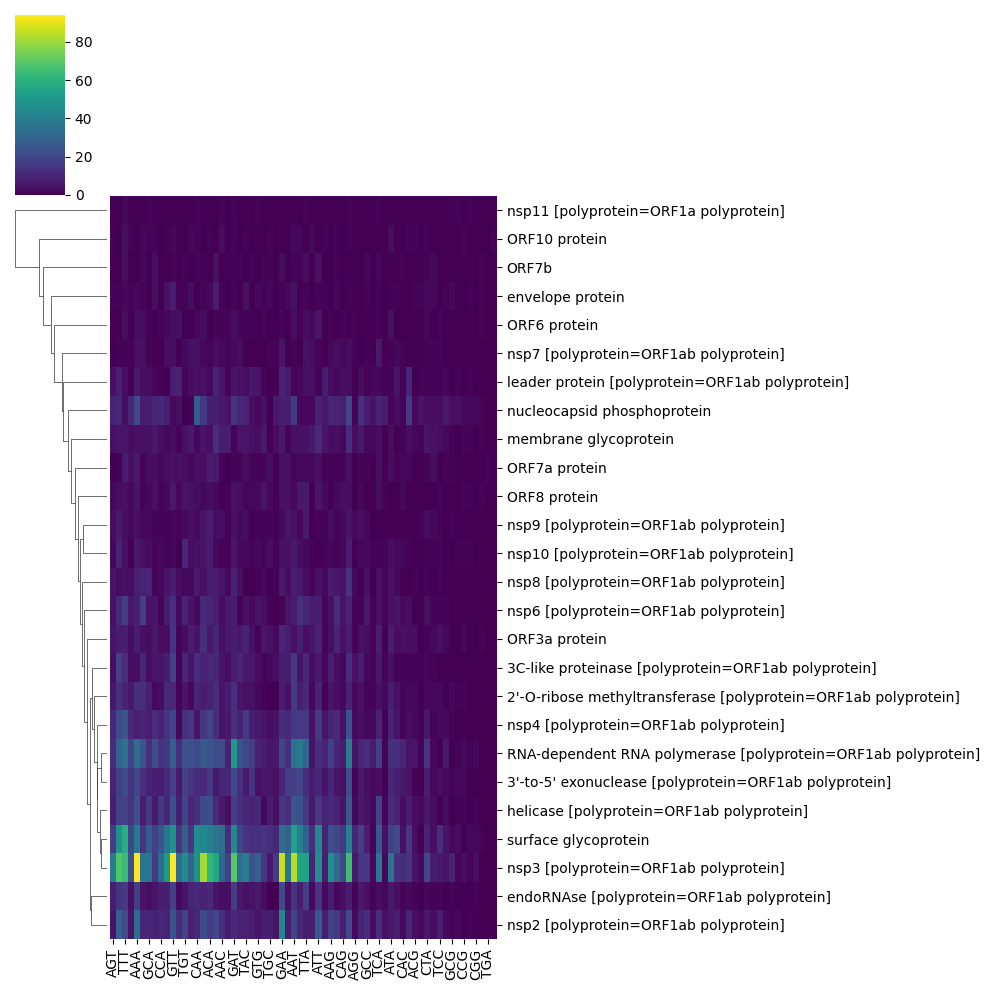

In [19]:
sns.clustermap(cdn_counts_df, cmap='viridis', figsize=(10, 10), metric='cosine',
               col_cluster=False, row_cluster=True, )

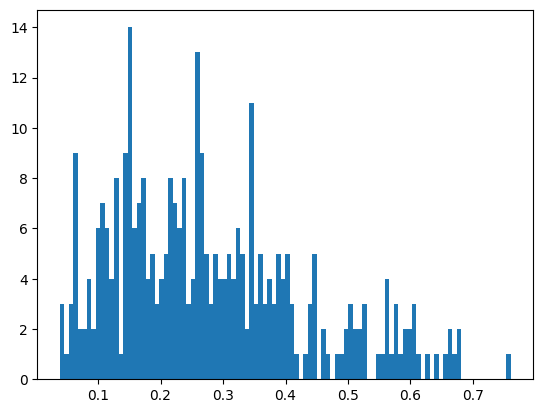

In [7]:
plt.hist(pdist(cdn_counts_df, 'cosine'), bins=100);

### Load matrix

In [8]:
clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,20A,AtoC,286,17202,0.016626,A,0.289620,0.007791,A>C
1,20A,AtoG,1617,17202,0.094001,A,0.289620,0.044050,A>G
2,20A,AtoT,515,17202,0.029938,A,0.289620,0.014029,A>T
3,20A,CtoA,339,17202,0.019707,C,0.137040,0.019518,C>A
4,20A,CtoG,130,17202,0.007557,C,0.137040,0.007484,C>G
5,20A,CtoT,7113,17202,0.413500,C,0.137040,0.409514,C>T
6,20A,GtoA,837,17202,0.048657,G,0.064987,0.101614,G>A
7,20A,GtoC,137,17202,0.007964,G,0.064987,0.016632,G>C
8,20A,GtoT,2670,17202,0.155210,G,0.064987,0.324148,G>T
9,20A,TtoA,565,17202,0.032845,T,0.508360,0.008769,T>A


In [16]:
possible_aa = list(amino_acid_codes.values())[:20]

In [20]:
eq_freq_df, _ = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freq_vec_cdn = eq_freq_df.set_index('cdn').loc[possible_codons, 'eq_freq'].values
eq_freq_vec_aa = eq_freq_df.groupby('aa')['eq_freq'].sum().loc[possible_aa].values
eq_freq_vec_aa

/home/kpotoh/mitofungen/sars-cov-2/sars-cov-2_aa_subst/utils.py:119: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


array([0.00199044, 0.00284005, 0.02131516, 0.0036268 , 0.01650364,
       0.00222026, 0.00084961, 0.00076166, 0.00947783, 0.11641184,
       0.15662635, 0.00499326, 0.00330395, 0.44136914, 0.00520158,
       0.05685866, 0.01169809, 0.00056217, 0.0969941 , 0.02036976])

### AA

In [21]:
_, Maa = prepare_exp_aa_subst(spectrum_20A)
Maa = (Maa.T / Maa.sum(axis=1)).T

In [22]:
Maa

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,0.221452,0.000000,0.000000,0.008644,0.000000,0.000000,0.008644,0.006630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014733,0.287133,0.090011,0.000000,0.000000,0.362752
Arg,0.000000,0.213691,0.000000,0.000000,0.145815,0.036182,0.000000,0.021015,0.036182,0.057709,0.230838,0.036182,0.057709,0.000000,0.011844,0.071505,0.005922,0.075405,0.000000,0.000000
Asn,0.000000,0.000000,0.595637,0.116655,0.000000,0.000000,0.000000,0.000000,0.020633,0.037153,0.000000,0.055482,0.000000,0.000000,0.000000,0.116655,0.020633,0.000000,0.037153,0.000000
Asp,0.010331,0.000000,0.134744,0.298246,0.000000,0.000000,0.027781,0.058411,0.022055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429829,0.018603
Cys,0.000000,0.055283,0.000000,0.000000,0.308385,0.000000,0.000000,0.008405,0.000000,0.000000,0.000000,0.000000,0.000000,0.444441,0.000000,0.034827,0.000000,0.009334,0.139324,0.000000
Gln,0.000000,0.126943,0.000000,0.000000,0.000000,0.209888,0.021569,0.000000,0.522472,0.000000,0.040429,0.056246,0.000000,0.000000,0.022453,0.000000,0.000000,0.000000,0.000000,0.000000
Glu,0.017778,0.000000,0.000000,0.413692,0.000000,0.037951,0.166189,0.100513,0.000000,0.000000,0.000000,0.231865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032012
Gly,0.015784,0.063999,0.000000,0.048216,0.153807,0.000000,0.048216,0.237247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048216,0.000000,0.076903,0.000000,0.307613
His,0.000000,0.058870,0.026084,0.010003,0.000000,0.027999,0.000000,0.000000,0.300589,0.000000,0.018749,0.000000,0.000000,0.000000,0.010412,0.000000,0.000000,0.000000,0.547293,0.000000


In [23]:
aa_init_freqs = {'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

aa_init_freqs = np.array([aa_init_freqs[x] for x in Maa.columns])
aa_init_freqs = aa_init_freqs / aa_init_freqs.sum()
aa_init_freqs

array([0.06752874, 0.03591954, 0.0545977 , 0.05244253, 0.03037767,
       0.03745895, 0.04536125, 0.0591133 , 0.01939655, 0.05264778,
       0.09544335, 0.05767652, 0.02124384, 0.05131363, 0.04043514,
       0.06783662, 0.07368637, 0.01139163, 0.04597701, 0.08015189])

In [25]:
for i in range(10):
    d = euclidean(simulate_markov_power(Maa.values, aa_init_freqs, i), eq_freq_vec_aa)
    print(i, d)

res_aa = simulate_markov_power(Maa.values, aa_init_freqs, 10000)

euclidean(res_aa, eq_freq_vec_aa)

0 0.4362881233052019
1 0.35540670110836753
2 0.2916381702596232
3 0.25100048912470574
4 0.22442628967396783
5 0.2065539504160052
6 0.19418650277114108
7 0.18539756605119107
8 0.17902144612398604
9 0.17432982035658062


0.1603217900546182

In [39]:
values, vectors = np.linalg.eig(Maa.values.T)
pi = vectors[:, np.isclose(values, 1)].real
pi = pi / pi.sum()
pi.flatten()

array([0.00615381, 0.00961757, 0.03127513, 0.00915547, 0.02682019,
       0.00274256, 0.00175694, 0.00418558, 0.01814157, 0.11565366,
       0.2067809 , 0.00541002, 0.01488244, 0.29771626, 0.01651341,
       0.08247588, 0.02873306, 0.00178199, 0.07662655, 0.04357702])

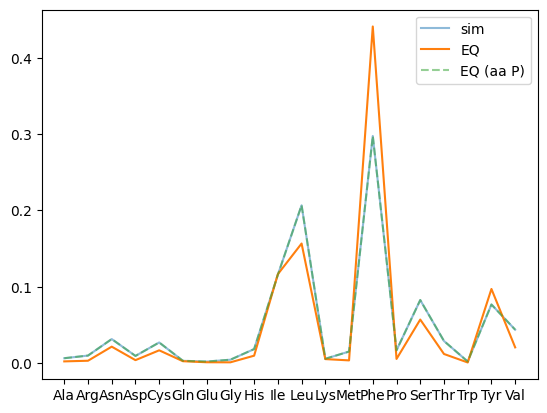

In [43]:
plt.plot(res_aa, label='sim', alpha=0.5)
plt.plot(eq_freq_vec_aa, label='EQ')
plt.plot(pi.flatten(), label='EQ (aa P)', linestyle='--', alpha=0.5)
plt.xticks(range(20), possible_aa)
plt.legend()

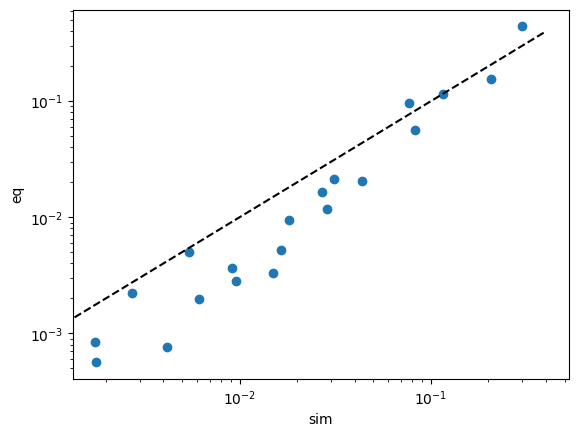

In [45]:
plt.scatter(res_aa, eq_freq_vec_aa)
plt.plot([0, 0.4], [0, 0.4], 'k--')
plt.xlabel('sim')
plt.ylabel('eq')
plt.xscale('log')
plt.yscale('log')

In [46]:
def simulate_markov_continual(transition_matrix, initial_vector, num_iterations, delta_t=0.01):
    pi = initial_vector.copy()
    data = [pi.copy()]
    Q = transition_matrix.copy()
    Q = Q - np.diag(np.sum(Q, axis=1))  # Convert to infinitesimal generator
    for _ in range(num_iterations):
        pi_new = pi + delta_t * (pi @ Q)
        pi_new = pi_new / pi_new.sum()
        data.append(pi_new.copy())
        if np.linalg.norm(pi_new - pi) < 1e-8:
            break
        pi = pi_new
    return data

In [114]:
sim_data = simulate_markov_continual(Maa.values, aa_init_freqs, 10, delta_t=0.01)
sim_data_df = pd.DataFrame(sim_data, columns=Maa.columns.values)
sim_data_df.index.name = 'replica'
sim_data_df_long = sim_data_df.melt(ignore_index=False, value_name='freq', var_name='aa').reset_index()
sim_data_df_long

,replica,aa,freq
0,0,Ala,0.067529
1,1,Ala,0.067119
2,2,Ala,0.066711
3,3,Ala,0.066307
4,4,Ala,0.065906
...,...,...,...
215,6,Val,0.080300
216,7,Val,0.080318
217,8,Val,0.080334
218,9,Val,0.080348


In [96]:
ref_freq_df = pd.DataFrame(
    {'replica':0, 'freq': dict(zip(possible_aa, aa_init_freqs))})\
        .reset_index(names='aa')
ref_freq_df.head()

,aa,replica,freq
0,Ala,0,0.067529
1,Arg,0,0.035920
2,Asn,0,0.054598
3,Asp,0,0.052443
4,Cys,0,0.030378


In [121]:
aa_content25 = pd.read_csv('./data/mean_aa_content_2025.csv', header=None, index_col=0)[1]
aa_content25 /= aa_content25.sum()
df_aa_content25 = aa_content25.sort_index().reset_index()
df_aa_content25.columns = ['aa', 'freq']
df_aa_content25['replica'] = -0.5
aa_content25vec = df_aa_content25['freq'].values
df_aa_content25

,aa,freq,replica
0,Ala,0.066920,-0.5
1,Arg,0.035798,-0.5
2,Asn,0.054159,-0.5
3,Asp,0.052431,-0.5
4,Cys,0.030503,-0.5
5,Gln,0.036961,-0.5
6,Glu,0.045344,-0.5
7,Gly,0.058903,-0.5
8,His,0.019772,-0.5
9,Ile,0.053464,-0.5


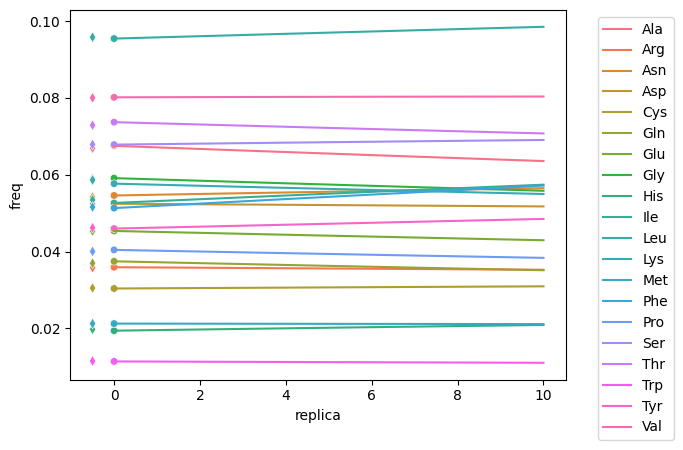

In [123]:
sns.lineplot(sim_data_df_long, x='replica', y='freq', hue='aa')
sns.scatterplot(ref_freq_df, hue='aa', x='replica', y='freq', legend=False, s=30)
sns.scatterplot(df_aa_content25, hue='aa', x='replica', y='freq', legend=False, s=30, marker='d')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [186]:
for i, p in enumerate(simulate_markov_continual(Maa.values, aa_init_freqs, 15, delta_t=0.001)):
    print(i, np.linalg.norm(p - aa_content25.loc[Maa.columns.values].values)*1000)

0 1.9038514931114563
1 1.842076501544579
2 1.7863691691784258
3 1.737300510435163
4 1.6954339591381702
5 1.6613007913452376
6 1.6353718013629335
7 1.6180278238963528
8 1.6095327319697375
9 1.6100129463398711
10 1.6194469268454257
11 1.637666558679462
12 1.6643701915738494
13 1.699145010228163
14 1.7414950473718127
15 1.790870807719793


In [203]:
df_change = pd.DataFrame([
    aa_init_freqs,
    simulate_markov_continual(Maa.values, aa_init_freqs, 9, delta_t=0.001)[-1],
    aa_content25.loc[Maa.columns.values],
], index=['refseq', 'sim1', 'gisaid25'], columns=Maa.columns.values
).T

# df_change['PE'] = (df_change['sim1'] - df_change['refseq']) / df_change['refseq']

df_change['PE_exp'] = (df_change['sim1'] - df_change['refseq']) / df_change['refseq']*100
# df_change['PE_exp'] = df_change['PE_exp'] / df_change['PE_exp'].abs()
df_change['PE_obs'] = (df_change['gisaid25'] - df_change['refseq']) / df_change['refseq']*100
# df_change['PE_obs'] = df_change['PE_obs'] / df_change['PE_obs'].abs()
df_change['correct_direction'] = df_change['PE_exp'].gt(0) == df_change['PE_obs'].gt(0)# & \
    # df_change['PE_obs'].abs().gt(0.5)

df_change

,refseq,sim1,gisaid25,PE_exp,PE_obs,correct_direction
Ala,0.067529,0.067161,0.066920,-0.545029,-0.900926,True
Arg,0.035920,0.035860,0.035798,-0.164491,-0.337612,True
Asn,0.054598,0.054776,0.054159,0.325927,-0.803272,False
Asp,0.052443,0.052382,0.052431,-0.116231,-0.021631,True
Cys,0.030378,0.030431,0.030503,0.176391,0.413500,True
Gln,0.037459,0.037243,0.036961,-0.575346,-1.328163,True
Glu,0.045361,0.045138,0.045344,-0.491305,-0.037280,True
Gly,0.059113,0.058809,0.058903,-0.514841,-0.356420,True
His,0.019397,0.019538,0.019772,0.727105,1.933841,True
Ile,0.052648,0.053088,0.053464,0.835402,1.550883,True


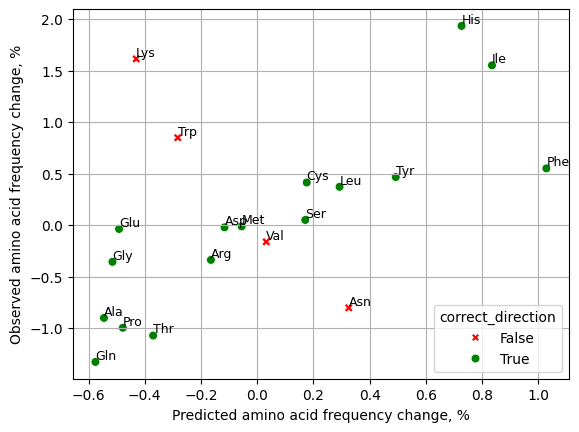

In [204]:
sns.scatterplot(df_change, x='PE_exp', y='PE_obs', 
                style='correct_direction', hue='correct_direction',
                markers={True: 'o', False: 'X'}, s=40, palette={True: 'green', False: 'red'})
for aa, row in df_change.iterrows():
    plt.text(row['PE_exp'], row['PE_obs'], aa, fontsize=9, ha='left', va='bottom')
plt.grid()
plt.xlabel('Predicted amino acid frequency change, %')
plt.ylabel('Observed amino acid frequency change, %')
# plt.xticks(np.arange(-100, 300, 50))
# plt.savefig('./figures/aa_freqs_change.pdf', bbox_inches='tight')
plt.show()

### CDN

In [ ]:
# TEST

transition_matrix = np.array([
    [0.25, 0.5, 0.25],
    [0, 0.5, 0.5],
    [0.33, 0.33, 0.34]
])
initial_vector = np.array([0, 0.5, 0.5])  # Starting in state 0
simulate_markov_power(transition_matrix, initial_vector, 1)

array([0.165, 0.415, 0.42 ])

In [124]:
def prepare_exp_cdn_subst(spectrum: pd.DataFrame, rate_col='rate', gc=1, save_path=None):
    df_changes = collect_possible_changes(gc=gc)
    spectrum_dict = spectrum.set_index('Mut')[rate_col].to_dict()

    df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)

    ## Calculate expected AA substitutions matrix
    exp_cdn_subst = df_changes[(df_changes.cdn1 != '*')&(df_changes.cdn2 != '*')]\
        .groupby(['cdn1', 'cdn2'])['rate'].sum().reset_index()
    
    if save_path:
        exp_cdn_subst.to_csv(save_path, float_format='%g', index=False)
    exp_cdn_subst_matrix = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
    exp_cdn_subst_matrix = exp_cdn_subst_matrix.loc[possible_codons, possible_codons]
    return exp_cdn_subst, exp_cdn_subst_matrix

In [125]:
_, exp_cdn_subst_matrix = prepare_exp_cdn_subst(spectrum_20A, 'rate', 1)
exp_cdn_subst_matrix = (exp_cdn_subst_matrix.T / exp_cdn_subst_matrix.sum(1)).T
# np.fill_diagonal(exp_cdn_subst_matrix, 0)
# exp_cdn_subst_matrix /= exp_cdn_subst_matrix.sum(axis=1)

In [128]:
values, vectors = np.linalg.eig(exp_cdn_subst_matrix.values.T)
pi = vectors[:, np.isclose(values, 1)].real
pi = pi / pi.sum()
pi.flatten()

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [145]:
exp_cdn_subst_matrix.sum(1)

cdn1
AAA    1.0
AAC    1.0
AAG    1.0
AAT    1.0
ACA    1.0
      ... 
TGT    1.0
TTA    1.0
TTC    1.0
TTG    1.0
TTT    1.0
Length: 64, dtype: float64

In [151]:
Q.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
cdn_spectrum_to_matrix()

In [166]:
Q

array([[-0.015625  ,  0.00061604,  0.00348301, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00053666, -0.015625  ,  0.00020579, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00276542,  0.00045264, -0.015625  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.015625  ,
         0.00021381,  0.01169869],
       [ 0.        ,  0.        ,  0.        , ...,  0.00047008,
        -0.015625  ,  0.00916155],
       [ 0.        ,  0.        ,  0.        , ...,  0.00380304,
         0.00057822, -0.015625  ]], shape=(64, 64))

In [165]:
Q = exp_cdn_subst_matrix.values
Q = Q - np.diag(np.sum(Q, axis=1))  # Convert to infinitesimal generator

values, vectors = np.linalg.eig(Q.T)
pi2 = vectors[:, np.isclose(values, 0)].real
pi2 = pi2 / pi2.sum()
pi2.flatten()

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

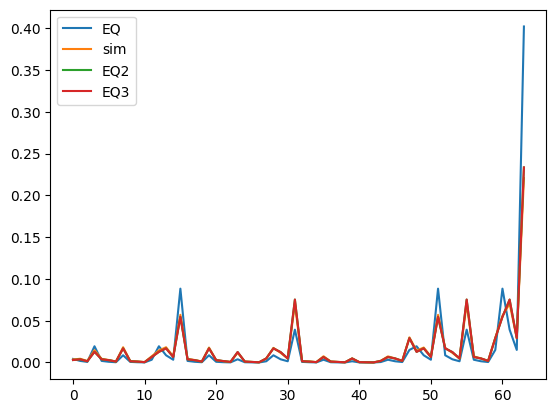

In [154]:
plt.plot(eq_freq_vec_cdn, label='EQ')
plt.plot(result, label='sim')
plt.plot(pi.flatten(), label='EQ2')
plt.plot(pi2.flatten(), label='EQ3')
plt.legend()

In [131]:
transition_matrix = exp_cdn_subst_matrix.copy().values
# transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

initial_vector = np.array([cdn_counts_dct[x] for x in possible_codons])
initial_vector = initial_vector / initial_vector.sum()

eq_freq_df, _ = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freq_vec = eq_freq_df.set_index('cdn').loc[possible_codons, 'eq_freq'].values

# Run 10 iterations
print(euclidean(initial_vector, eq_freq_vec))
# for i in range(10):
#     result = simulate_markov_power(transition_matrix, initial_vector, i)
#     print(euclidean(result, eq_freq_vec))
result = simulate_markov_power(transition_matrix, initial_vector, 10)
# print(euclidean(result, eq_freq_vec))
# print(eq_freq_vec.sum(), initial_vector.sum(), result.sum(), result.round(3))

0.3989245159724756


/home/kpotoh/mitofungen/sars-cov-2/sars-cov-2_aa_subst/utils.py:119: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


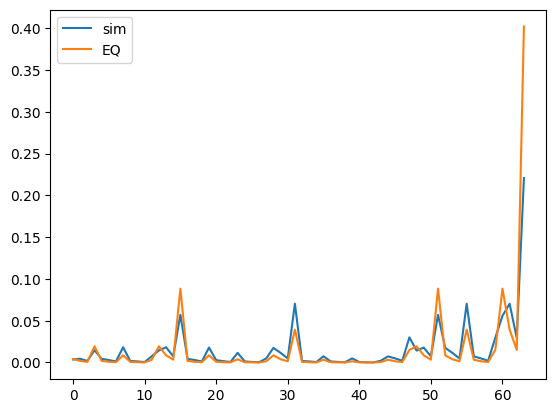

In [287]:
plt.plot(result, label='sim')
plt.plot(eq_freq_vec, label='EQ')
plt.legend()

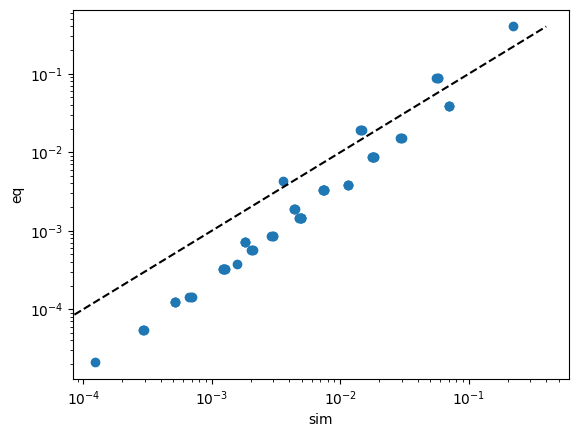

In [266]:
plt.scatter(result, eq_freq_vec)
plt.plot([0, 0.4], [0, 0.4], 'k--')
plt.xlabel('sim')
plt.ylabel('eq')
plt.xscale('log')
plt.yscale('log')

In [ ]:
# Run 100 iterations
result = simulate_markov_power(transition_matrix, initial_vector, 1)
print(result)

[0.01766681 0.01493436 0.01730691 0.01456401 0.01806449 0.01593828
 0.01585003 0.01682262 0.01629439 0.01531913 0.01395805 0.01568287
 0.01583625 0.01624106 0.01671092 0.01744115 0.01606366 0.01801877
 0.01523116 0.01648605 0.01442255 0.01409631 0.01544474 0.01680914
 0.01659947 0.01715618 0.01413501 0.01592202 0.01434678 0.01508118
 0.01434343 0.0145671  0.01596697 0.01424543 0.01572329 0.01401728
 0.01419798 0.01600666 0.01484067 0.01482251 0.01491952 0.01592255
 0.01600862 0.01566378 0.0160215  0.01598121 0.01529994 0.01415771
 0.01446273 0.0156333  0.01578723 0.01529678 0.01637806 0.01558807
 0.01628312 0.01632156 0.01558149 0.01426011 0.01594996 0.01589215
 0.01672819 0.01529541 0.01433922 0.01505212]
